In [87]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [88]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [90]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 10
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [91]:
# Uses the GeoDataFrame class from geopandas to convert the DataFrame df into a GeoDataFrame.
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

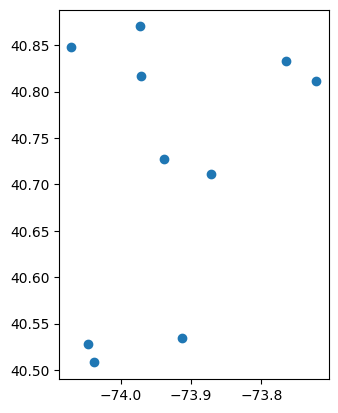

In [92]:
gdf.plot()

In [6]:
# find five nearest neighbors for each point, not including itself
k = 3          #set num of nearest neighbors
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1] #Selects the top k neighbors from the sorted indices. 1: skips the self-index (since the distance to itself is 0), and k + 1 ensures that k nearest neighbors are selected

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()
# gdf["neighbors"]: a new column named neighbors is created 

C:\Users\jiang\AppData\Local\Temp\ipykernel_39692\892204520.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [7]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.81669),"[3, 2, 9]"
1,POINT (-73.87089 40.71156),"[2, 0, 7]"
2,POINT (-73.93834 40.72722),"[1, 0, 3]"
3,POINT (-73.97307 40.87024),"[0, 9, 2]"
4,POINT (-74.04581 40.52841),"[6, 5, 2]"
5,POINT (-73.91246 40.53485),"[6, 4, 1]"
6,POINT (-74.03745 40.50809),"[4, 5, 2]"
7,POINT (-73.76494 40.83305),"[8, 1, 2]"
8,POINT (-73.72180 40.81126),"[7, 1, 2]"
9,POINT (-74.06994 40.84800),"[3, 0, 2]"


In [8]:
def create_lines(r): #This is the function definition for create_lines, with r as the parameter.
    lines = [] #Creates an empty list lines to store the line segments that will be generated.
    for i, neighbor in enumerate(r.neighbors): #Uses enumerate to iterate over each neighbor in r.neighbors, where i is the index and neighbor is the neighbor index.
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry])) #对于每个邻居，创建一个 LineString 对象，表示从 r.geometry 到 gdf.loc[neighbor].geometry 的线段。r.geometry 是当前几何对象，gdf.loc[neighbor].geometry 是邻居的几何对象。将创建的 LineString 对象添加到 lines 列表中。
    return MultiLineString(lines) #Combines all the generated line segments into a MultiLineString object and returns it.

In [9]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

# gdf["line_geometry"]: This is a new column in the GeoDataFrame, named line_geometry. The result from the apply method is assigned to this new column.
# 将 create_lines 函数生成的 MultiLineString 对象存储在 gdf 的 line_geometry 列中。每一行的 line_geometry 列将包含一个表示该几何对象与其所有邻居之间线段的 MultiLineString 对象。

In [10]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.81669),"[3, 2, 9]","MULTILINESTRING ((-73.97071 40.81669, -73.9730..."
1,POINT (-73.87089 40.71156),"[2, 0, 7]","MULTILINESTRING ((-73.87089 40.71156, -73.9383..."
2,POINT (-73.93834 40.72722),"[1, 0, 3]","MULTILINESTRING ((-73.93834 40.72722, -73.8708..."
3,POINT (-73.97307 40.87024),"[0, 9, 2]","MULTILINESTRING ((-73.97307 40.87024, -73.9707..."
4,POINT (-74.04581 40.52841),"[6, 5, 2]","MULTILINESTRING ((-74.04581 40.52841, -74.0374..."
5,POINT (-73.91246 40.53485),"[6, 4, 1]","MULTILINESTRING ((-73.91246 40.53485, -74.0374..."
6,POINT (-74.03745 40.50809),"[4, 5, 2]","MULTILINESTRING ((-74.03745 40.50809, -74.0458..."
7,POINT (-73.76494 40.83305),"[8, 1, 2]","MULTILINESTRING ((-73.76494 40.83305, -73.7218..."
8,POINT (-73.72180 40.81126),"[7, 1, 2]","MULTILINESTRING ((-73.72180 40.81126, -73.7649..."
9,POINT (-74.06994 40.84800),"[3, 0, 2]","MULTILINESTRING ((-74.06994 40.84800, -73.9730..."


In [11]:
#This code creates a new GeoDataFrame containing the line segment geometries. 

lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

#lines_gdf = gpd.GeoDataFrame(): 创建一个新的 GeoDataFrame 对象，变量名为 lines_gdf。
#gdf[["line_geometry"]]: 从原始的 GeoDataFrame 'gdf' 中选择 line_geometry 列。返回一个只包含 line_geometry 列的 DataFrame。
#geometry="line_geometry: 指定 line_geometry 列作为新 GeoDataFrame 的几何列。这是因为 GeoDataFrame 需要知道哪一列包含几何信息。
#Sets the coordinate reference system (CRS) for the new GeoDataFrame to EPSG:4326, which is consistent with the CRS of the original GeoDataFrame.


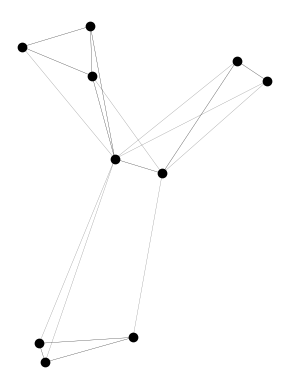

In [12]:
# English version: This code plots and saves the line segment geometries and the original point data as a background. 

ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
#Plots the line segment geometries in lines_gdf.
gdf.plot(ax=ax, color="black").set_axis_off()
#在之前绘制的轴对象 ax 上绘制 gdf 中的几何数据（点数据）。
#ax=ax: When you call gdf.plot(ax=ax, color="black"), the ax=ax argument tells the plot method to use the Axes object stored in the ax variable for plotting the new data (i.e., the point data from gdf).
#This ensures that the new plot (point data) is drawn on the same set of axes as the previous plot (line segments), allowing them to appear together in the same plot.

plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)
#Saves the plotted image as a PDF file named 'lines.pdf' using plt.savefig

In [13]:
# This code saves all the geometry data from the line_geometry column of gdf into a file named edges.geojson, with the file format being GeoJSON.
gdf["line_geometry"].to_file("edges.geojson", driver="GeoJSON")

#这是 GeoDataFrame 'gdf' 中的一列，包含了线段几何数据 (MultiLineString 对象) 
#.to_file 是 geopandas 库中的 method，用于将 GeoDataFrame 的几何数据导出到文件中。
#driver="GeoJSON" 指定了文件的格式为 GeoJSON 



In [14]:
gdf.head(3)   # Give top five data 

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.81669),"[3, 2, 9]","MULTILINESTRING ((-73.97071 40.81669, -73.9730..."
1,POINT (-73.87089 40.71156),"[2, 0, 7]","MULTILINESTRING ((-73.87089 40.71156, -73.9383..."
2,POINT (-73.93834 40.72722),"[1, 0, 3]","MULTILINESTRING ((-73.93834 40.72722, -73.8708..."


<Axes: >

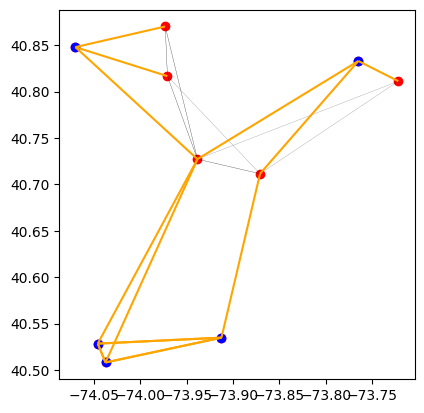

In [15]:
# plot the lines for a single point
s = gdf.sample(5)    # Give five random points, and name them as 's' 
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue") #'s' is the five points 
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [93]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"   # Search for NTA name 
).json() 

#requests.get(...): 这个函数用于发送一个 HTTP GET 请求到指定的 URL (This function is used to send an HTTP GET request to the specified URL.) 
#URL: 这是一个来自纽约市开放数据门户的 API 端点 URL。43nn-pn8j 是餐厅检查数据集的 ID。NTA=MN09 是一个查询参数，用于筛选特定的邻里统计区域 (NTA)，MN09 代表曼哈顿的一个特定区域。$limit=2000 限制返回的记录数为 2000 条。
#This method converts the HTTP response content into a JSON object. After the requests.get call, .json() parses （解析） the response and returns it as a Python dictionary or list, depending on the structure of the JSON data.

In [94]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000" 
    ).json() 

[{'camis': '50140436',
  'dba': 'JUST SALAD',
  'boro': 'Manhattan',
  'building': '2853',
  'street': 'BROADWAY',
  'zipcode': '10025',
  'phone': '7323004245',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-07-27T06:00:16.000',
  'latitude': '40.804636759173',
  'longitude': '-73.966363656199',
  'community_board': '109',
  'council_district': '07',
  'census_tract': '019900',
  'bin': '1075440',
  'bbl': '1018947501',
  'nta': 'MN09'},
 {'camis': '41647571',
  'dba': 'PEKING GARDEN',
  'boro': 'Manhattan',
  'building': '3163',
  'street': 'BROADWAY',
  'zipcode': '10027',
  'phone': '2128653600',
  'cuisine_description': 'Chinese',
  'inspection_date': '2021-08-16T00:00:00.000',
  'action': 'Violations were cited in the following area(s).',
  'violation_code': '02B',
  'violation_description': 'Hot food item not held at or above 140º F.',
  'critical_flag': 'Critical',
  'score': '12',
  'record_date': '2024-07-27T06:00:1

In [95]:
# This code converts a list of restaurant data into a GeoDataFrame with geographic coordinates.  

mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

#mh_restaurants： This variable contains the restaurant data retrieved from the API, which is in JSON format. 
#‘geometry’ is an argument that specifies which column of data should be used as the geometrical information for the GeoDataFrame.
#‘gpd.points_from_xy‘ is a function that creates Point geometries from given longitude and latitude values.
#[float(x["longitude"]) for x in mh_restaurants]：这个列表推导式从 mh_restaurants 中的每一条记录提取纬度值，并将其转换为浮点数。这提供了 Point 几何体的 y 坐标。 

In [96]:
# handle missing values in the 'GeoDataFrame' 

mh_restaurants.fillna("na", inplace=True)

#fillna("na"): This method is used to replace missing values (NaN) in the 'GeoDataFrame' with a specified value, which in this case is "na".
#这个参数表示应该直接在 mh_restaurants DataFrame 上应用更改，直接修改原始 DataFrame。如果 inplace=False（默认值），将返回一个新的 DataFrame，缺失值被填充，而原始 DataFrame 保持不变。

In [97]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'inspection_date', 'critical_flag', 'record_date', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta', 'cuisine_description', 'action', 'violation_code',
       'violation_description', 'score', 'inspection_type', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

In [98]:
# removes duplicate rows from the GeoDataFrame based on a specific column.

mh_restaurants.drop_duplicates(subset="camis", inplace=True)

#drop_duplicates(subset="camis"): This method is used to remove duplicate rows based on the values in the specified column(s).
#subset="camis": 这个 method 用于根据指定列的值去除重复的行 
#inplace=True: This parameter indicates that the operation should be applied directly to the mh_restaurants DataFrame, modifying it in place. If inplace=False (the default), a new DataFrame with duplicates removed would be returned, and the original DataFrame would remain unchanged.



In [99]:
mh_restaurants.grade.value_counts()

#mh_restaurants.grade: 访问 'mh_restaurants' GeoDataFrame 中的 'grade' 列

grade
na    80
A     66
N      9
B      7
C      4
Z      3
P      1
Name: count, dtype: int64

In [100]:
mh_restaurants.cuisine_description.value_counts() 

#mh_restaurants.cuisine: 访问 'mh_restaurants' GeoDataFrame 中的 'cuisine_description' 列

cuisine_description
American                          27
Coffee/Tea                        20
na                                16
Chinese                           10
Pizza                             10
Italian                            8
Mexican                            8
Japanese                           5
Hamburgers                         4
Sandwiches                         4
French                             4
Asian/Asian Fusion                 4
Juice, Smoothies, Fruit Salads     4
Thai                               3
Ethiopian                          3
Indian                             3
Other                              3
Fusion                             2
Tex-Mex                            2
Greek                              2
Donuts                             2
Latin American                     2
Frozen Desserts                    2
Middle Eastern                     2
Hawaiian                           2
Mediterranean                      2
Bakery Products/De

## build graph to allow us to search


In [101]:
#计算并使 'mh_restaurants' GeoDataFrame 的边界框赋值给变量 mh_bbox 

mh_bbox = mh_restaurants.total_bounds

#total_bounds: 是 GeoDataFrame 的一个属性，返回包含 GeoDataFrame 中所有几何体的边界框 
#边界框以数组形式返回，格式为 [minx, miny, maxx, maxy]，其中 minx 和 miny 是最小的 x 和 y 坐标，maxx 和 maxy 是最大的 x 和 y 坐标。

In [102]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [103]:
#use the osmnx library to create a street network graph within the bounding box defined by mh_bbox. 

mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

#ox.graph_from_bbox(...): This function from the osmnx library creates a graph from OpenStreetMap data within a bounding box.
#network_type: The type of network to retrieve, in this case "walk" for walkable paths.
#mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0]: These are the values extracted from the mh_bbox array to define the bounding box

C:\Users\jiang\AppData\Local\Temp\ipykernel_39692\1430674790.py:3: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [104]:
mh_network

In [105]:
# convert a street network graph into GeoDataFrames for nodes and edges using the osmnx library

mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network) 
#ox.graph_to_gdfs(mh_network): osmnx 库的这个函数将图对象转换为两个 GeoDataFrames：一个用于 node，一个用于 edge 
#mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network): 这行代码将生成的 GeoDataFrames 分别赋值给变量 mh_net_nodes和mh_net_edges`

In [106]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


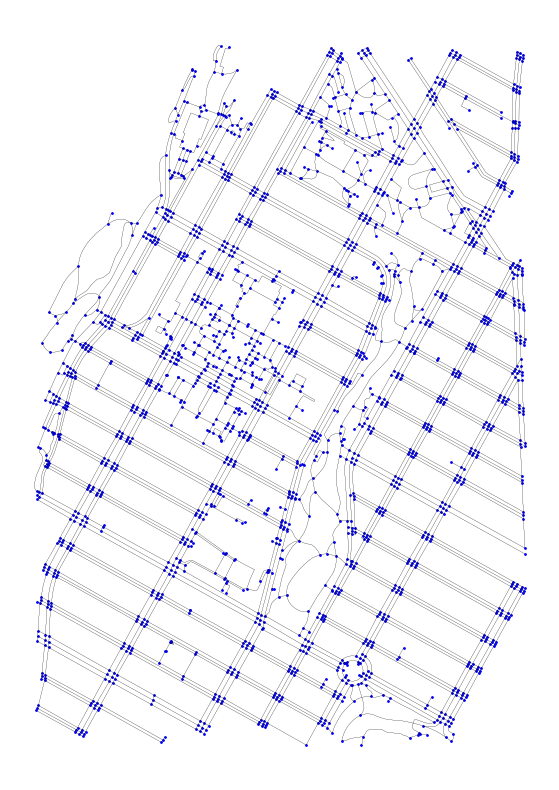

In [107]:
ax = mh_net_edges.plot(
    color="black", 
    linewidth=0.1, 
    figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="blue", markersize=1).set_axis_off()

#mh_net_edges.plot(...): This line plots the edges of the street network. 
#mh_net_nodes.plot(ax=ax, color="blue", markersize=1).set_axis_off(): This line plots the nodes of the street network on the same axes as the edges.
   #ax=ax: 在 ax 中捕获的现有绘图上绘制节点。
   #markersize=1: 将节点标记的大小设置为 1 
   #隐藏坐标轴以获得更干净的绘图。

In [108]:
avery_hall = Point(-73.9614755, 40.8081037)   # Start point 

### get directions between avery hall and a random restaurant using osmnx


In [109]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, avery_hall.x, avery_hall.y)      #   Original Point 
#从 'mh_restaurants' GeoDataFrame 中随机选择一个样本，选取一个餐厅
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]      #   Destination 

In [110]:
orig

2340960635

In [111]:
dest

7004396259

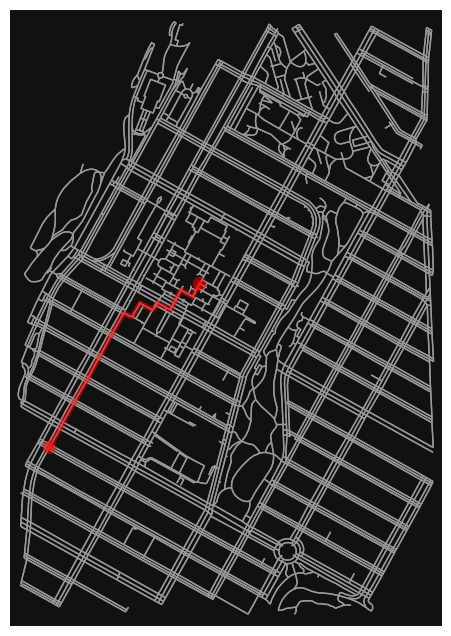

In [112]:
# find the shortest path between nodes, minimizing travel time, then plot it

route = ox.shortest_path(mh_network, orig, dest, weight="length")
#ox.shortest_path(...)：这是 osmnx 库中的函数，用于计算网络图中两个节点之间的最短路径 
   #orig：起点节点（Avery Hall 最近的节点）。
   #dest：终点节点（随机选取餐厅最近的节点）。 
   #weight="length"：路径计算时使用的权重 (weight)，这里指定为边 (edge) 的长度。
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)
#ox.plot_graph_route(...)：这是 osmnx 库中的函数，用于可视化给定的最短路径。 
  #node_size=0：设置节点的大小为 0，这样节点不会在图中显示。 


In [113]:
#Calculate the shortest path from start to destination
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]
#ox.routing.route_to_gdf(...): 这是 osmnx 库中的函数，用于将路径转换为 GeoDataFrame。GeoDataFrame 是一种特殊的数据框，包含地理数据，便于空间分析和可视化。
   #["length"]: 从 GeoDataFrame 中提取 "length" 列，这列包含路径中每条边的长度信息。

# convert meters to miles
sum(edge_lengths) / 1609.34

0.5127226067829048

In [114]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

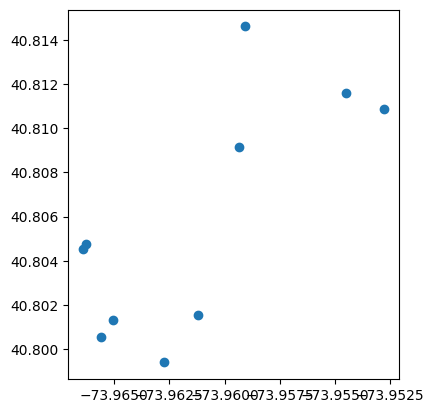

In [115]:
mh_pizza.plot()

In [116]:
mh_pizza

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,...,nta,cuisine_description,action,violation_code,violation_description,score,inspection_type,grade,grade_date,geometry
7,50073062,SLICED BY HARLEM PIZZA,Manhattan,1215,AMSTERDAM AVENUE,10027,9177141411,2022-08-30T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,02G,Cold TCS food item held above 41 °F; smoked or...,0,Cycle Inspection / Initial Inspection,na,na,POINT (-73.95934 40.80915)
33,50066109,KORONET PIZZA,Manhattan,2848,BROADWAY,10025,2122221566,2023-02-08T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",22,Cycle Inspection / Re-inspection,B,2023-02-08T00:00:00.000,POINT (-73.96641 40.80454)
40,50046844,DOMINO'S,Manhattan,965,AMSTERDAM AVENUE,10025,2122222000,2022-04-05T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,0,Cycle Inspection / Initial Inspection,na,na,POINT (-73.96507 40.80129)
103,40605511,DOMINO'S,Manhattan,409,WEST 125 STREET,10027,2122803200,2024-02-26T00:00:00.000,Not Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,20-08,Failure to post or conspicuously post healthy ...,na,Administrative Miscellaneous / Initial Inspection,na,na,POINT (-73.95451 40.81159)
124,50065324,GIOVANNI'S ITALIAN PIZZERIA,Manhattan,1011,COLUMBUS AVENUE,10025,2126637000,2022-08-18T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,04L,Evidence of mice or live mice in establishment...,44,Cycle Inspection / Initial Inspection,na,na,POINT (-73.96121 40.80155)
176,41012973,MAMA'S PIZZERIA,Manhattan,941,AMSTERDAM AVENUE,10025,2125319797,2022-02-10T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizi...,9,Cycle Inspection / Initial Inspection,A,2022-02-10T00:00:00.000,POINT (-73.96561 40.80055)
204,50107497,TRUFA PIZZERIA,Manhattan,3161,BROADWAY,10027,9172386330,2024-04-30T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,06C,"Food, supplies, or equipment not protected fro...",60,Cycle Inspection / Initial Inspection,N,na,POINT (-73.95908 40.81462)
227,40388419,FAMOUS FAMIGLIA PIZZERIA,Manhattan,2859,BROADWAY,10025,2128651234,2022-03-17T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,29,Cycle Inspection / Re-inspection,C,2022-03-17T00:00:00.000,POINT (-73.96626 40.80478)
356,50131886,IPIZZA,Manhattan,351,WEST 125 STREET,10027,9172658973,2023-04-11T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Establishment re-opened by DOHMH.,06C,"Food, supplies, or equipment not protected fro...",5,Pre-permit (Operational) / Reopening Inspection,P,2023-04-11T00:00:00.000,POINT (-73.95280 40.81086)
727,50134260,PIZZA HUT,Manhattan,940,COLUMBUS AVENUE,10025,4692840850,2024-04-04T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,MN09,Pizza,Violations were cited in the following area(s).,04A,Food Protection Certificate (FPC) not held by ...,12,Pre-permit (Operational) / Initial Inspection,A,2024-04-04T00:00:00.000,POINT (-73.96277 40.79939)


In [117]:
mh_greek = mh_restaurants[mh_restaurants.cuisine_description == "Greek"]

<Axes: >

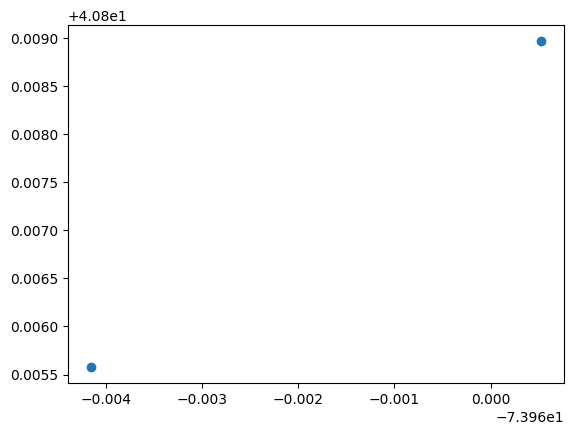

In [118]:
mh_greek.plot()

In [119]:
def distance_from_point(row, origin):
    #row: A row from a pandas DataFrame that contains the coordinates of a point.
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    #Finds the nearest node in the network to the given point (row.geometry.x and row.geometry.y).
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    #weight="length": Uses edge length as the weight for path calculation.
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]
    #ox.routing.route_to_gdf(...): Converts the route to a GeoDataFrame.
    #["length"]: Extracts the lengths of each edge in the route.

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    #route_geom: Contains the geometry of the route as a GeoDataFrame.
    route_geom = route_geom.geometry.unary_union
    #unary_union: Combines all the geometries in the GeoDataFrame into a single geometry (useful for plotting). 

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}
    #"distance": sum(edge_lengths) / 1609.34: The distance of the route in miles.
    #route_geom": The combined geometry of the route. 

In [120]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

#mh_pizza: 这是一个 pandas DataFrame，包含了所有提供披萨（Pizza）餐厅的数据。
#mh_pizza.apply(...)： apply 方法用于将指定的函数应用到 DataFrame 的每一行或每一列。在这个例子中，我们将 distance_from_point 函数应用到每一行。
#distance_from_avery： 这是我们之前定义的函数，用于计算从每个点到原点 orig 的距离以及路径的几何形状。
#origin=orig: origin 是传递给 distance_from_point 函数的参数，表示计算距离的起点（原点）。
#axis=1: 指定函数 distance_from_point 应用于 DataFrame 的每一行（axis=1 表示按行操作）

C:\Users\jiang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [121]:
mh_pizza

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,...,cuisine_description,action,violation_code,violation_description,score,inspection_type,grade,grade_date,geometry,distance_from_avery
7,50073062,SLICED BY HARLEM PIZZA,Manhattan,1215,AMSTERDAM AVENUE,10027,9177141411,2022-08-30T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,02G,Cold TCS food item held above 41 °F; smoked or...,0,Cycle Inspection / Initial Inspection,na,na,POINT (-73.95934 40.80915),"{'distance': 0.24633514359923947, 'route_geom'..."
33,50066109,KORONET PIZZA,Manhattan,2848,BROADWAY,10025,2122221566,2023-02-08T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",22,Cycle Inspection / Re-inspection,B,2023-02-08T00:00:00.000,POINT (-73.96641 40.80454),"{'distance': 0.42345557806305695, 'route_geom'..."
40,50046844,DOMINO'S,Manhattan,965,AMSTERDAM AVENUE,10025,2122222000,2022-04-05T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,0,Cycle Inspection / Initial Inspection,na,na,POINT (-73.96507 40.80129),"{'distance': 0.5797606472218425, 'route_geom':..."
103,40605511,DOMINO'S,Manhattan,409,WEST 125 STREET,10027,2122803200,2024-02-26T00:00:00.000,Not Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,20-08,Failure to post or conspicuously post healthy ...,na,Administrative Miscellaneous / Initial Inspection,na,na,POINT (-73.95451 40.81159),"{'distance': 0.6333391328122088, 'route_geom':..."
124,50065324,GIOVANNI'S ITALIAN PIZZERIA,Manhattan,1011,COLUMBUS AVENUE,10025,2126637000,2022-08-18T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,04L,Evidence of mice or live mice in establishment...,44,Cycle Inspection / Initial Inspection,na,na,POINT (-73.96121 40.80155),"{'distance': 0.5567779338113761, 'route_geom':..."
176,41012973,MAMA'S PIZZERIA,Manhattan,941,AMSTERDAM AVENUE,10025,2125319797,2022-02-10T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizi...,9,Cycle Inspection / Initial Inspection,A,2022-02-10T00:00:00.000,POINT (-73.96561 40.80055),"{'distance': 0.6302254340288566, 'route_geom':..."
204,50107497,TRUFA PIZZERIA,Manhattan,3161,BROADWAY,10027,9172386330,2024-04-30T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,06C,"Food, supplies, or equipment not protected fro...",60,Cycle Inspection / Initial Inspection,N,na,POINT (-73.95908 40.81462),"{'distance': 0.5736600096934148, 'route_geom':..."
227,40388419,FAMOUS FAMIGLIA PIZZERIA,Manhattan,2859,BROADWAY,10025,2128651234,2022-03-17T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,29,Cycle Inspection / Re-inspection,C,2022-03-17T00:00:00.000,POINT (-73.96626 40.80478),"{'distance': 0.42345557806305695, 'route_geom'..."
356,50131886,IPIZZA,Manhattan,351,WEST 125 STREET,10027,9172658973,2023-04-11T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Establishment re-opened by DOHMH.,06C,"Food, supplies, or equipment not protected fro...",5,Pre-permit (Operational) / Reopening Inspection,P,2023-04-11T00:00:00.000,POINT (-73.95280 40.81086),"{'distance': 0.7203083251519257, 'route_geom':..."
727,50134260,PIZZA HUT,Manhattan,940,COLUMBUS AVENUE,10025,4692840850,2024-04-04T00:00:00.000,Critical,2024-07-27T06:00:12.000,...,Pizza,Violations were cited in the following area(s).,04A,Food Protection Certificate (FPC) not held by ...,12,Pre-permit (Operational) / Initial Inspection,A,2024-04-04T00:00:00.000,POINT (-73.96277 40.79939),"{'distance': 0.7407987125

In [122]:
# explode the dictionary into separate columns

mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)
#pd.concat: 是 pandas 提供的一个函数，用于沿着指定轴将多个 DataFrame 合并成一个 DataFrame。
#mh_pizza.drop(["distance_from_avery"], axis=1): drop 方法用于删除 DataFrame 中的指定列或行。axis=1 表示删除列（而不是行）。
#apply(pd.Series): 将 distance_from_avery 列中的字典应用到 pd.Series 中，将字典的键展开成 DataFrame 的列。这样可以将 distance_from_avery 列中的字典转换成多个列，每个键成为一列。
#axis=1,指定沿列的方向进行合并（水平合并）。


In [123]:
# creates a GeoDataFrame for the mh_pizza DataFrame with a specific geometry column.

mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

#gpd.GeoDataFrame 是 geopandas 库中的一个类，用于处理地理数据。它扩展了常规的 pandas DataFrame，支持空间数据 
#mh_pizza 是你的原始 DataFrame，包含各种列，包括你想用于空间操作的 route_geom 列。 
#geometry="route_geom": 指定 mh_pizza 中的 route_geom 列作为新 GeoDataFrame 的几何列。geometry 列包含几何形状（如线条、点、面），表示空间数据。


Text(0.5, 1.0, 'Distance from Avery Hall to \n Morningside Heights Pizza Restaurants')

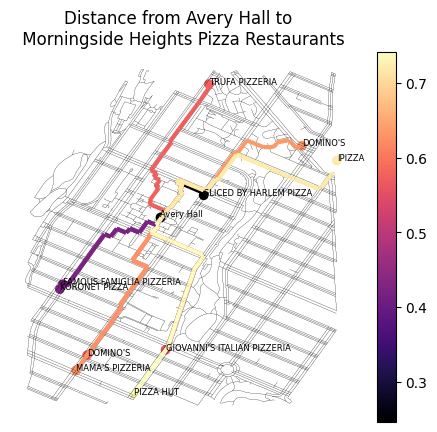

In [124]:
#使用 geopandas 和 matplotlib 库可视化空间数据

ax = gpd.GeoSeries(avery_hall).plot(color="black")
#作用: 绘制 avery_hall（一个点或几何对象），颜色为黑色。 解释: gpd.GeoSeries(avery_hall) 将 avery_hall 转换为 GeoSeries，用于绘图。返回的 ax 是图形的坐标轴对象。
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
#作用: 在之前创建的图上绘制网络边缘（mh_net_edges），颜色为黑色，线宽为 0.1。解释: mh_net_edges 是网络的边缘数据，这里将它们绘制在同一个坐标轴 ax 上，使用黑色和较细的线宽。
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
#绘制路线。作用: 绘制 mh_pizza_routes（披萨店的路线），颜色根据 "distance" 列的值进行着色，使用 "magma" 颜色映射。解释: mh_pizza_routes 的路线根据 distance 列的值上色，cmap="magma" 指定了颜色映射，linewidth=3 设置了线宽。
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()
#绘制披萨店位置。作用: 绘制 mh_pizza（披萨店的位置），根据 "distance" 列的值上色，并显示图例。设置坐标轴不可见。解释: mh_pizza 数据点根据 distance 列的值上色，legend=True 表示显示图例，set_axis_off() 隐藏坐标轴。


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(avery_hall.x, avery_hall.y, "Avery Hall", fontsize=6)
#作用: 在图上标记每个披萨店的位置，显示其名称和 avery_hall 的名称。解释: 使用 ax.text() 在图上添加文本标签，显示每个披萨店的名称和 avery_hall 的名称。

# title
plt.title("Distance from Avery Hall to \n Morningside Heights Pizza Restaurants")

In [125]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
7,SLICED BY HARLEM PIZZA,0.246335
33,KORONET PIZZA,0.423456
227,FAMOUS FAMIGLIA PIZZERIA,0.423456
124,GIOVANNI'S ITALIAN PIZZERIA,0.556778
204,TRUFA PIZZERIA,0.573660
40,DOMINO'S,0.579761
176,MAMA'S PIZZERIA,0.630225
103,DOMINO'S,0.633339
356,IPIZZA,0.720308
727,PIZZA HUT,0.740799


<Axes: >

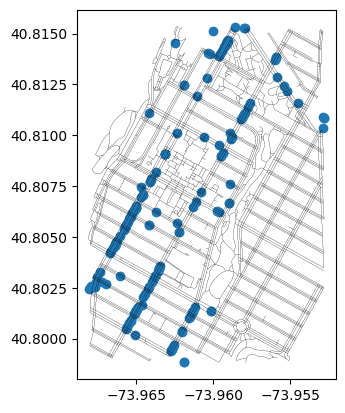

In [126]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

<Axes: >

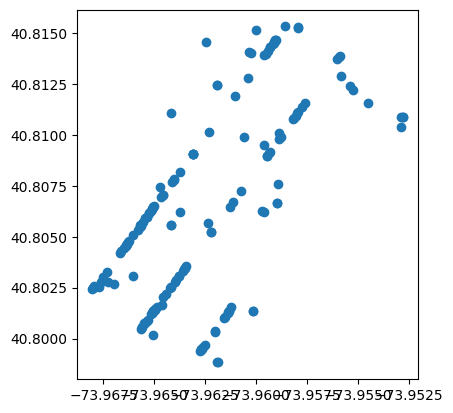

In [127]:
mh_restaurants.plot()

In [39]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [129]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


In [130]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)
#mh_net_nodes["h3"]: 为 mh_net_nodes 数据框添加一列名为 h3 的新列。
#mh_net_nodes.apply(): 对 mh_net_nodes 数据框的每一行应用一个函数。
#lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9): 定义一个匿名函数，计算每个节点的 H3 索引。
   #x 是数据框的每一行，x.geometry.centroid 获取行中几何对象的中心点，centroid.y 和 centroid.x 分别获取中心点的纬度和经度。
   #h3.geo_to_h3(latitude, longitude, resolution) 函数用于计算给定纬度和经度及分辨率的 H3 索引，这里分辨率设为 9。

In [131]:
mh_net_nodes["h3"] # hexagon 

osmid
42421737       892a10088b3ffff
42421741       892a1008887ffff
42421745       892a100888fffff
42421852       892a1008c33ffff
42421857       892a1008c07ffff
                    ...       
12029862491    892a1008c67ffff
12029862492    892a1008c2bffff
12029862493    892a1008c67ffff
12029862494    892a1008c67ffff
12036804275    892a1008d4bffff
Name: h3, Length: 1989, dtype: object

In [132]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)
#mh_net_nodes["geometry"]: 为 mh_net_nodes 数据框添加或更新 geometry 列。
#mh_net_nodes["h3"].apply(): 对 mh_net_nodes 数据框的 h3 列的每一个元素应用一个函数。
#定义一个匿名函数，将 H3 索引转换为地理边界。x 是 h3 列中的每一个 H3 索引。h3.h3_to_geo_boundary(x) 将 H3 索引 x 转换为其对应的地理边界。

C:\Users\jiang\AppData\Local\Temp\ipykernel_39692\2144275691.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [133]:
mh_net_nodes["geometry"]

osmid
42421737       ((40.79992952883274, -73.96197935638261), (40....
42421741       ((40.80251489146535, -73.96422198910369), (40....
42421745       ((40.802400032652685, -73.96850268201203), (40...
42421852       ((40.8133159556837, -73.9560683870264), (40.81...
42421857       ((40.81590187030861, -73.95831132341029), (40....
                                     ...                        
12029862491    ((40.810386193911, -73.96666998042426), (40.80...
12029862492    ((40.81050098294262, -73.96238856074181), (40....
12029862493    ((40.810386193911, -73.96666998042426), (40.80...
12029862494    ((40.810386193911, -73.96666998042426), (40.80...
12036804275    ((40.8026295918606, -73.95994128961736), (40.8...
Name: geometry, Length: 1989, dtype: object

In [134]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

#mh_net_nodes["geometry"]: 选择 mh_net_nodes 数据框中的 geometry 列。
#mh_net_nodes["geometry"].apply(): 作用: 对 geometry 列中的每一个元素应用一个函数。
#lambda x: Polygon([(y, x) for x, y in x]): 定义一个匿名函数，将坐标列表转换为 Polygon 对象。
   #x 是 geometry 列中的每一个元素，通常是一个包含顶点坐标的列表。[(y, x) for x, y in x] 将每个坐标对 (x, y) 转换为 (y, x)，以确保坐标顺序正确（Polygon 构造函数需要的格式）。

In [135]:
mh_net_nodes.crs = "EPSG:4326"
#为 mh_net_nodes 数据框设置坐标参考系统（CRS），指定其为 EPSG:4326。

In [136]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [137]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
...,...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff
12029862492,40.808069,-73.964123,crossing,4,"POLYGON ((-73.96239 40.81050, -73.96450 40.809...",892a1008c2bffff
12029862493,40.808442,-73.965017,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff


<Axes: >

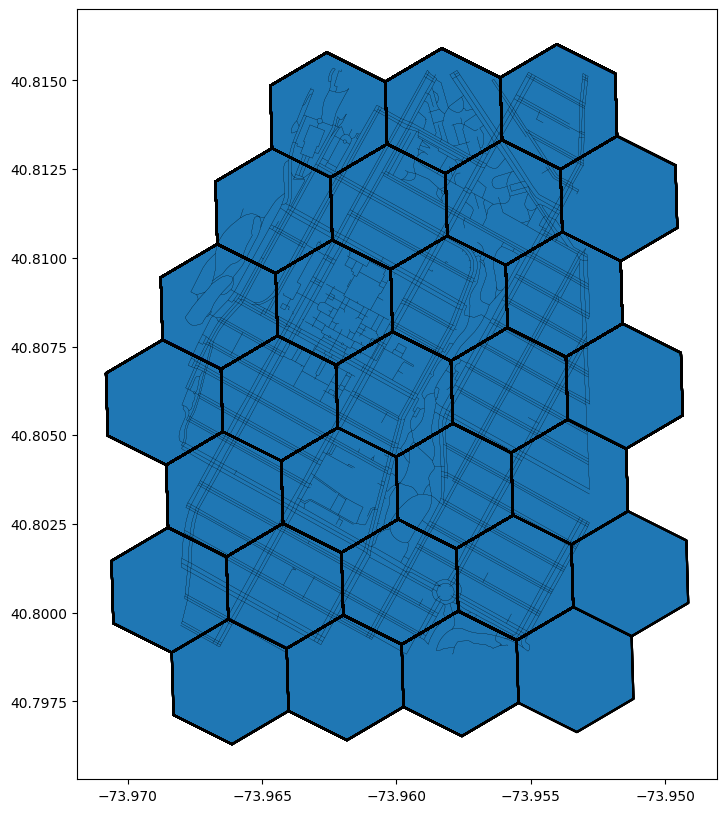

In [138]:
ax = mh_net_nodes.plot(figsize=(10, 10))
#绘制 mh_net_nodes 数据框的几何形状，生成一个10x10大小的图。
mh_net_nodes.boundary.plot(ax=ax, color="black")
#绘制 mh_net_nodes 数据框的几何边界，并将其添加到现有的图 (ax) 上。
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()
#绘制 mh_net_edges 数据框的几何形状，并将其添加到现有的图 (ax) 上。

In [139]:
from lonboard import Map, PolygonLayer
#导入了 lonboard 库中的两个类：Map 和 PolygonLayer。这是用于创建和管理地图及其图层的库，通常用于地理空间数据的可视化。

In [141]:
#使用了 lonboard 库的 PolygonLayer 和 Map 类，将 mh_net_nodes 的几何数据转化为地图上的多边形图层，并在地图上显示出来。

layer = PolygonLayer.from_geopandas(
    #"from_geopandas" method：从 GeoDataFrame 创建一个多边形图层。
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
#创建一个包含指定图层的地图对象。解释: 将前面创建的多边形图层 layer 添加到地图中。
m
#显示地图。

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [142]:
#删除 mh_net_nodes 数据框中在 h3 列中重复的行，只保留第一个出现的行。

mh_net_nodes.drop_duplicates(subset="h3", inplace=True)
#inplace=True：直接在原数据框中进行操作，而不返回新的数据框。

In [81]:
# Do Not Run. For Explain the Code Above

import pandas as pd

# 假设 mh_net_nodes 是一个包含以下数据的 DataFrame
data = {
    "h3": ["abc", "def", "abc", "ghi"],
    "geometry": ["geom1", "geom2", "geom1", "geom3"]
}
mh_net_nodes = pd.DataFrame(data)

# 删除在 "h3" 列中重复的行
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

print(mh_net_nodes)

    h3 geometry
0  abc    geom1
1  def    geom2
3  ghi    geom3


In [143]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)
#使用 libpysal 库中的 Queen 类，根据 mh_net_nodes 数据框创建了一个基于女王邻接规则（Queen contiguity rule）的空间权重矩阵。
#lps.weights.Queen：libpysal 中的 "Queen" class 用于生成基于女王邻接规则的空间权重矩阵。
#from_dataframe(mh_net_nodes)：从 GeoDataFrame 创建空间权重矩阵。mh_net_nodes 是一个包含几何数据的 GeoDataFrame。

C:\Users\jiang\AppData\Local\Temp\ipykernel_39692\2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)


In [144]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}
#将 w 中的邻居信息转换为一个字典，字典的键是每个节点，值是该节点的邻居节点列表。
#w.neighbors: w 是一个空间权重矩阵对象，w.neighbors 返回一个字典，其中的键是每个节点的索引，值是该节点的邻居节点的索引列表。
#w.neighbors.items() 返回 w.neighbors 字典中的所有键值对。
#k: v for k, v in w.neighbors.items()：这是一个字典解析，将 w.neighbors 中的每个键值对 k, v 复制到新的字典 neighbors 中。
#w.neighbors.items() 返回 w.neighbors 字典中的所有键值对。

In [145]:
neighbors # [edge, edge, edge]

{0: [1, 18, 17, 23],
 1: [0, 2, 18, 6, 23, 12],
 2: [1, 6, 23],
 3: [16, 4, 21, 22, 8, 11],
 4: [8, 3, 5, 22],
 5: [8, 24, 4],
 6: [1, 2, 7, 12, 13],
 7: [19, 6, 25, 27, 12, 13],
 8: [3, 4, 5, 24, 27, 11],
 9: [16, 10, 20],
 10: [16, 19, 20, 9, 11, 15],
 11: [16, 3, 19, 8, 10, 27],
 12: [1, 18, 19, 6, 7, 15],
 13: [25, 6, 7],
 14: [17, 18, 20, 26, 28, 15],
 15: [18, 19, 20, 10, 12, 14],
 16: [3, 21, 9, 10, 11],
 17: [0, 18, 26, 14],
 18: [0, 1, 17, 12, 14, 15],
 19: [7, 27, 10, 11, 12, 15],
 20: [9, 10, 28, 14, 15],
 21: [16, 3, 22],
 22: [3, 4, 21],
 23: [0, 1, 2],
 24: [8, 25, 27, 5],
 25: [24, 27, 13, 7],
 26: [17, 28, 14],
 27: [19, 7, 8, 24, 11, 25],
 28: [26, 20, 14]}

In [147]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

##使用 NetworkX 库创建了一个图 (Graph) 对象 G，其中 neighbors 字典定义了图的节点及其相邻节点。

In [148]:
# get the path between two nodes (hexagon)
path = nx.shortest_path(G, 6, 22)
#使用 NetworkX 库找到节点 6 和节点 22 之间的最短路径。
#nx.shortest_path：NetworkX 库中的函数，用于计算图中两点之间的最短路径。


C:\Users\jiang\AppData\Local\Temp\ipykernel_39692\2532966678.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
C:\Users\jiang\AppData\Local\Temp\ipykernel_39692\2532966678.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


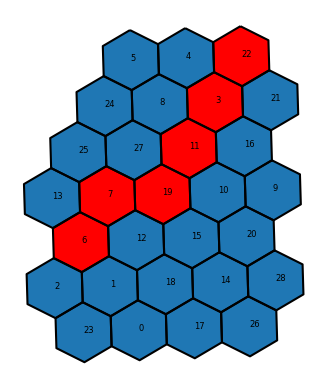

In [149]:
# plot the path
ax = mh_net_nodes.plot()
#mh_net_nodes.plot()：绘制 GeoDataFrame 中的所有几何图形，返回一个 Matplotlib 的 Axes 对象 ax
mh_net_nodes.boundary.plot(ax=ax, color="black")
#mh_net_nodes.boundary.plot(ax=ax, color="black")：在同一个 Axes 对象 ax 上绘制节点的边界，颜色为黑色。
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()
#mh_net_nodes.iloc[path].plot(ax=ax, color="red")：在同一个 Axes 对象 ax 上绘制最短路径上的节点，颜色为红色，并隐藏坐标轴。

# label cells with their index
for x, y, label in zip(
    #在每个节点的中心位置标记节点标签。
    mh_net_nodes.geometry.centroid.x,
    #mh_net_nodes.geometry.centroid.x：获取每个节点的几何中心的 x 坐标。
    mh_net_nodes.geometry.centroid.y,
    #mh_net_nodes.geometry.centroid.y：获取每个节点的几何中心的 y 坐标。
    neighbors.keys(),
    #neighbors.keys()：获取邻接字典中的所有节点。
):
    ax.text(x, y, label, fontsize=6)
    #ax.text(x, y, label, fontsize=6)：在指定的坐标位置 (x, y) 上绘制文本标签，字体大小为 6。